NN modified from [pytorch object detection tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [ ]:
# mount google drive where the zipped file of images located
from google.colab import drive
drive.mount('/content/gdrive')

In [67]:
# list the files in drive and make sure the zip file exists
!ls "/content/gdrive/My Drive"

 Test.zip  'Untitled spreadsheet.gsheet'  'WMS Update Pack.rar'


In [68]:
# unzip the file
!unzip "/content/gdrive/My Drive/Test.zip"

Archive:  /content/gdrive/My Drive/Test.zip
   creating: Test/
   creating: Test/Bush/
   creating: Test/Bush/Images/
  inflating: Test/Bush/Images/OleanderCNN00001.png  
  inflating: Test/Bush/Images/OleanderCNN00002.png  
  inflating: Test/Bush/Images/OleanderCNN00003.png  
  inflating: Test/Bush/Images/OleanderCNN00004.png  
  inflating: Test/Bush/Images/OleanderCNN00005.png  
  inflating: Test/Bush/Images/OleanderCNN00006.png  
  inflating: Test/Bush/Images/OleanderCNN00007.png  
  inflating: Test/Bush/Images/OleanderCNN00008.png  
   creating: Test/Bush/Labels/
  inflating: Test/Bush/Labels/OleanderCNN00001_mask1.png  
  inflating: Test/Bush/Labels/OleanderCNN00002_mask1.png  
  inflating: Test/Bush/Labels/OleanderCNN00003_mask1.png  
  inflating: Test/Bush/Labels/OleanderCNN00003_mask2.png  
  inflating: Test/Bush/Labels/OleanderCNN00003_mask3.png  
  inflating: Test/Bush/Labels/OleanderCNN00004_mask1.png  
  inflating: Test/Bush/Labels/OleanderCNN00004_mask2.png  
  inflating: T

In [69]:
# view a sample image
from PIL import Image
Image.open('Test/Oleander Plant/Images/OleanderCNN00001.png')

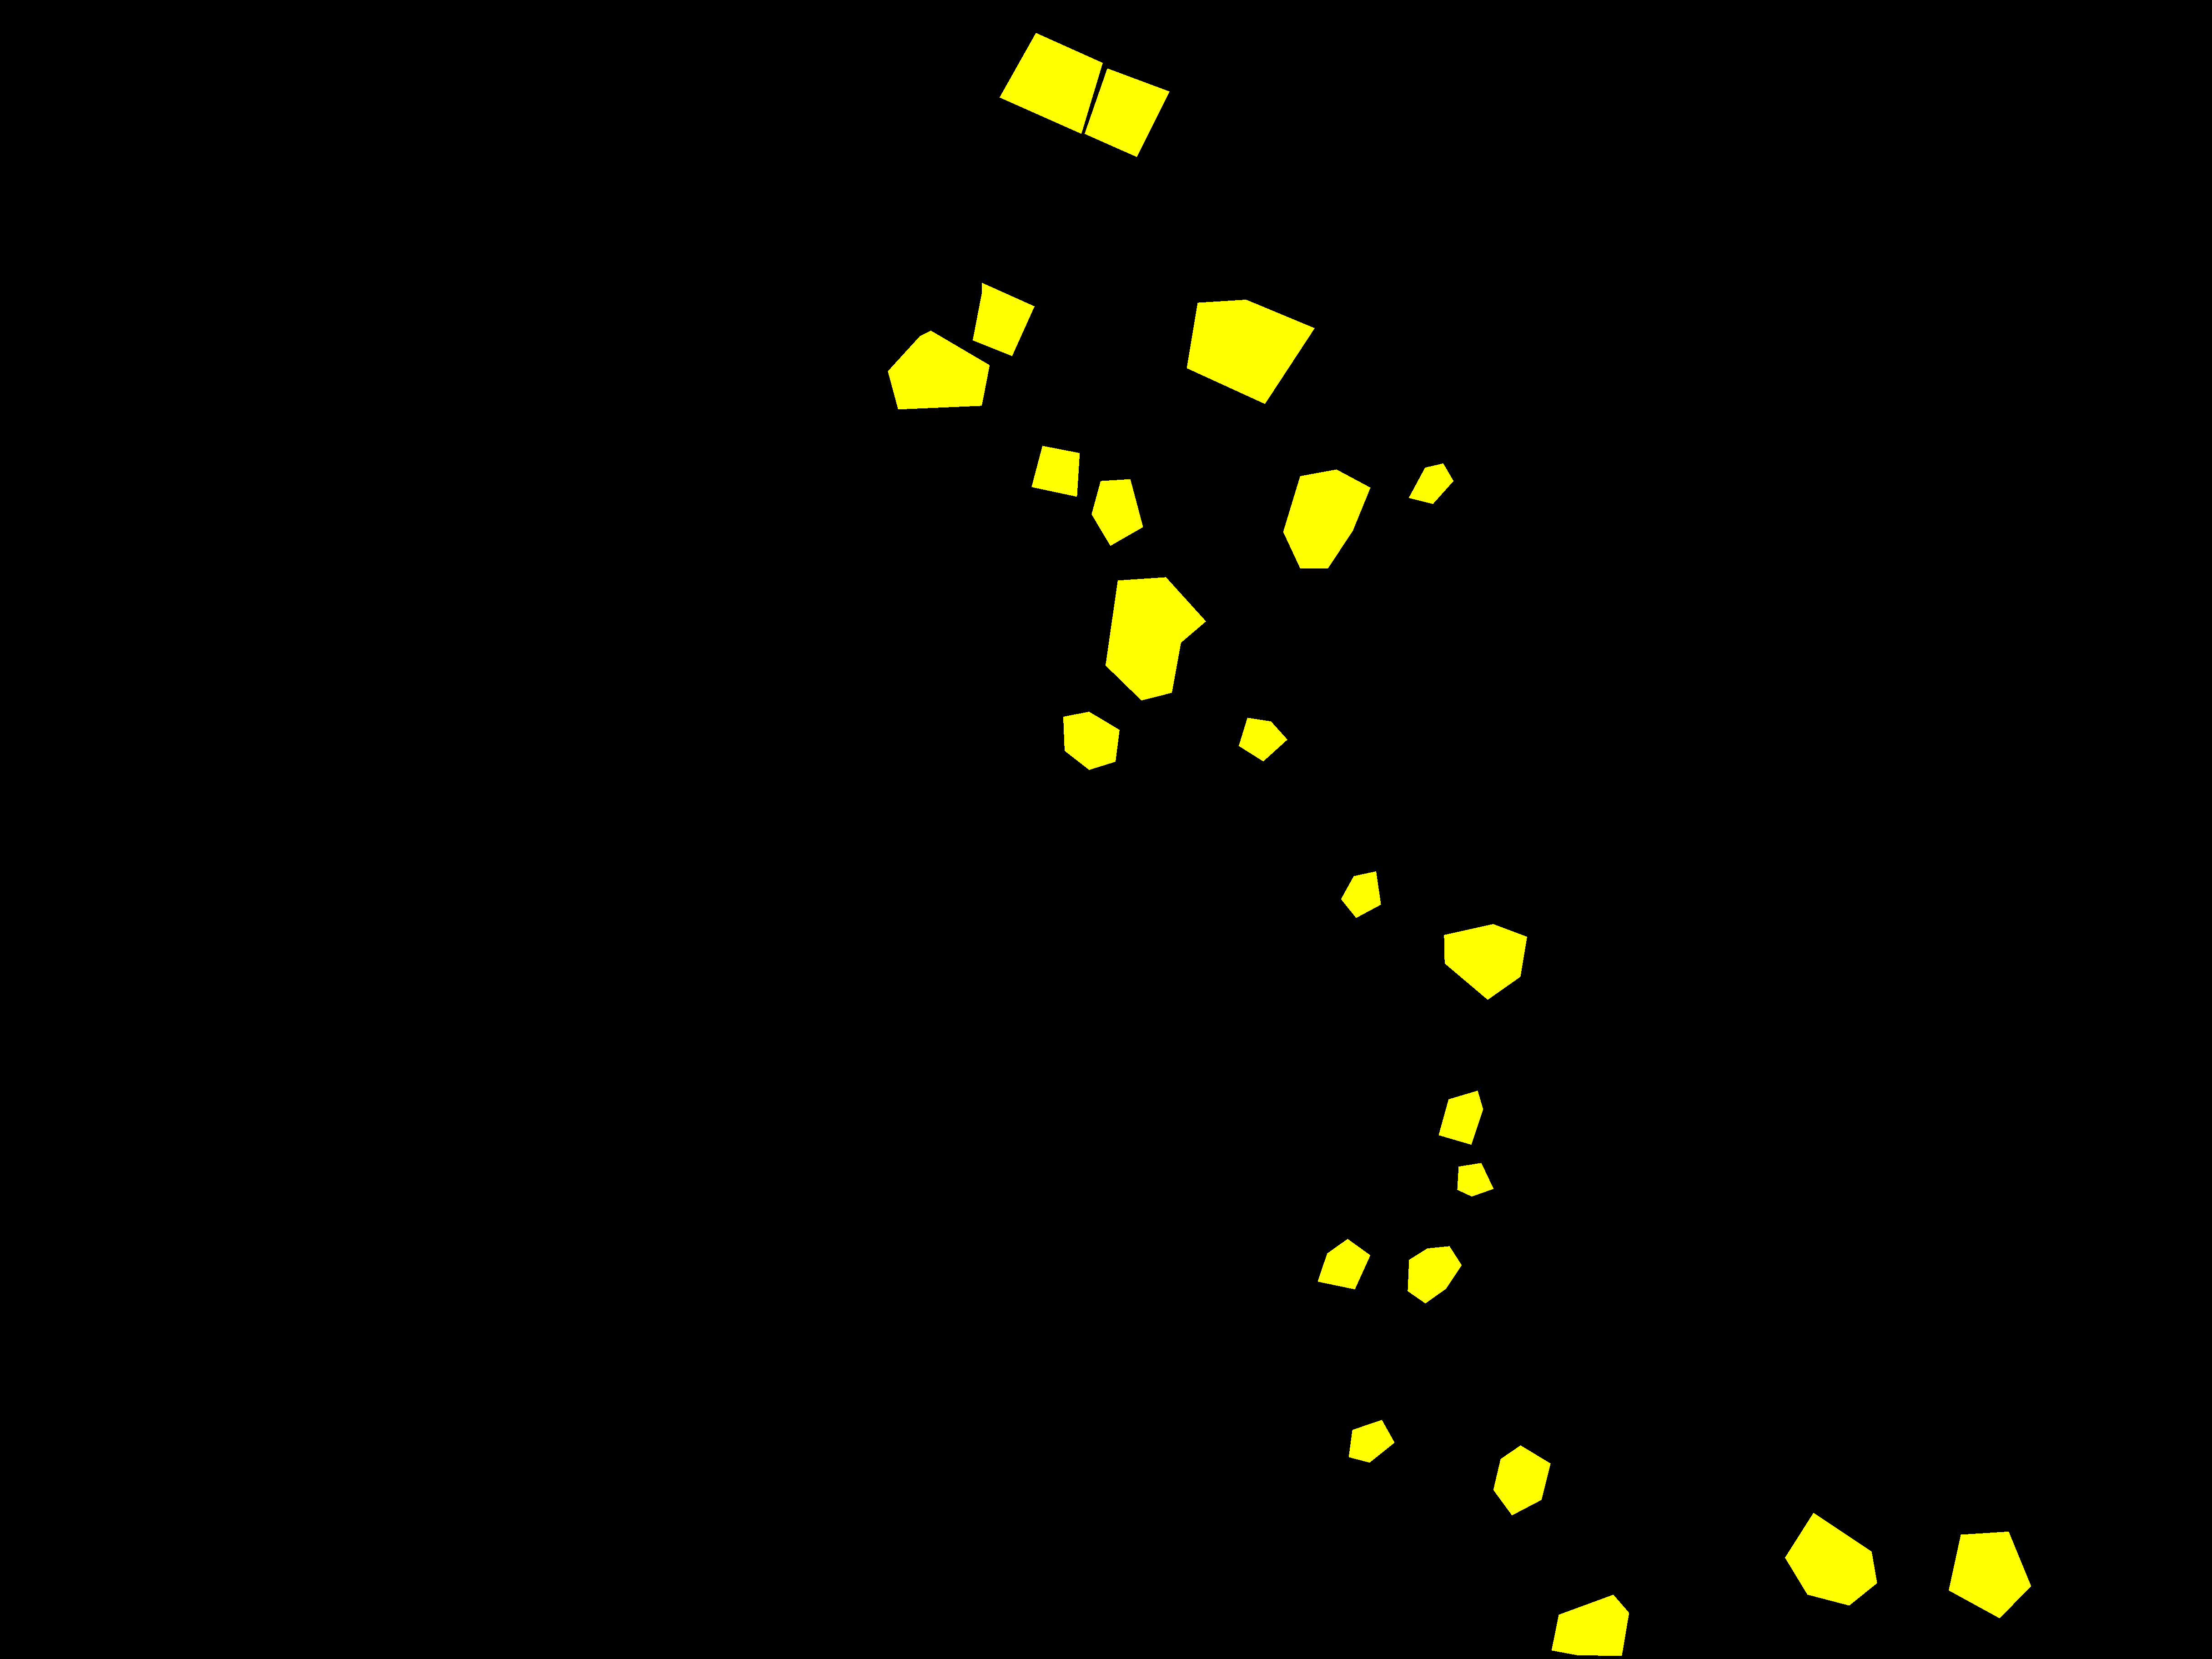

In [70]:
# view the mask of the sample image
mask = Image.open('Test/Oleander Plant/Masks/OleanderCNN00001_mask.png').convert('L')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask. - comment from pytorch tutorial

# NB: when generating the mask from overlaid labels, all mask instances were
# of the same luminosity, thus all instances would appear as the same color
# may consider save each instance at different luminosity in the mask and 
# add more colors to the palette
mask.putpalette([
    0, 0, 0, # black background
    255, 255, 0, # label is yellow
])
mask

In [71]:
# define the dataset
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class NNDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to 
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "Masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        mask_path = os.path.join(self.root, "Masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # convert masks to grayscale mode to distinguish background and objects
        mask = Image.open(mask_path).convert("L")

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [72]:
# import Mask R-CNN architecture for fine-tuning
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [73]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version


In [15]:
# determine the version of cuda
!cat /usr/local/cuda/version.txt

CUDA Version 11.0.228


In [74]:
# import helper functions
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
        # NB: may add rotation and resize operations
    return T.Compose(transforms)

In [77]:
# use our dataset and defined transformations
dataset = NNDataset('Test/Oleander Plant', get_transform(train=True))
dataset_test = NNDataset('Test/Oleander Plant', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
print(len(dataset))
# NB: change the portion of train and test set according to the size of the whole dataset
dataset = torch.utils.data.Subset(dataset, indices[:-6])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-6:])
print(len(dataset))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

86
80


In [78]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and label
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# train for epochs
# NB: change number of epochs according to the size of dataset
# few epochs for small dataset to avoid overfitting
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 5 iteration
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=5)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/40]  eta: 0:06:10  lr: 0.000133  loss: 0.8005 (0.8005)  loss_classifier: 0.0644 (0.0644)  loss_box_reg: 0.0497 (0.0497)  loss_mask: 0.6483 (0.6483)  loss_objectness: 0.0339 (0.0339)  loss_rpn_box_reg: 0.0042 (0.0042)  time: 9.2719  data: 8.4169  max mem: 6881
Epoch: [0]  [ 5/40]  eta: 0:03:12  lr: 0.000773  loss: 0.5927 (0.6006)  loss_classifier: 0.0644 (0.0657)  loss_box_reg: 0.0601 (0.0689)  loss_mask: 0.3936 (0.4213)  loss_objectness: 0.0280 (0.0389)  loss_rpn_box_reg: 0.0042 (0.0059)  time: 5.5057  data: 4.7238  max mem: 6881
Epoch: [0]  [10/40]  eta: 0:02:33  lr: 0.001414  loss: 0.5697 (0.5660)  loss_classifier: 0.0577 (0.0629)  loss_box_reg: 0.0682 (0.0649)  loss_mask: 0.3936 (0.3977)  loss_objectness: 0.0304 (0.0348)  loss_rpn_box_reg: 0.0042 (0.0057)  time: 5.1144  data: 4.3612  max mem: 6881
Epoch: [0]  [15/40]  eta: 0:01:47  lr: 0.002054  loss: 0.5390 (0.5471)  loss_classifier: 0.0568 (0.0618)  loss_box_reg: 0.0725 (0.0699)  loss_mask: 0.3427 (0.3741)  loss_ob

In [ ]:
# test
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
  
prediction

In [ ]:
# view verification image
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
# view prediction
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())